In [1]:
import os

def move_to_parent_dir():
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    os.chdir(parent_directory)
    print("Working directory:", os.getcwd())

move_to_parent_dir() 

Working directory: c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19


In [2]:
# get test data
import matplotlib.pyplot as plt
import numpy as np
from tools import get_Tapes
from numba import njit
raw_tapes = get_Tapes(125,0)
tapes_data = [t["Price"].resample("1min").last().ffill().to_numpy() for t in raw_tapes] # resample down to 1 min

# define broker
@njit
def broker(actor, price_data: np.array, starting_cash: int):
    time_index = 0
    final_time_index = price_data.shape[0]
    num_stocks = np.zeros_like(price_data)
    cash_value = np.zeros_like(price_data)
    cash_value[0] = starting_cash

    while True:
        action = actor(price_data[:time_index], cash_value[time_index], num_stocks[time_index])

        if action == 1: # buy one stock
            if cash_value[time_index] >= price_data[time_index]:
                cash_value[time_index] = cash_value[time_index] - price_data[time_index]
                num_stocks[time_index] = num_stocks[time_index] + 1

        elif action == 2: # sell one stock
            if num_stocks[time_index] > 0:
                num_stocks[time_index] = num_stocks[time_index] - 1
                cash_value[time_index] = cash_value[time_index] + price_data[time_index]
        else: # do nothing
            pass


        time_index += 1
        if time_index >= final_time_index:
            break

        num_stocks[time_index] = num_stocks[time_index - 1]
        cash_value[time_index] = cash_value[time_index - 1]

    total_value = num_stocks * price_data + cash_value
    profit = (total_value[-1] / starting_cash) - 1
    
    return num_stocks, cash_value, total_value, profit

# generate folds
def generate_folds(tapes_data, n_folds=5):
    tapes_data = np.array(tapes_data)
    fold_size = len(tapes_data) // n_folds
    
    for i in range(n_folds):
        start_index = i * fold_size
        end_index = (i + 1) * fold_size if i < n_folds - 1 else len(tapes_data)
        
        test_indices = np.arange(start_index,end_index,1, dtype=int)
        # Test split
        test_data = tapes_data[test_indices]
        
        # Training split
        train_data = np.delete(tapes_data, test_indices, axis=0)
        
        yield train_data, test_data

def display_results(results, data):
    plt.figure(figsize=(20,5))
    plt.plot(results[2], 'r', label = "actor")
    plt.twinx()
    plt.plot(data, 'b', label = "data")
    plt.legend()
    plt.show()

Opening UoB_Set01_2025-01-02tapes.csv
Opening UoB_Set01_2025-01-03tapes.csv
Opening UoB_Set01_2025-01-06tapes.csv
Opening UoB_Set01_2025-01-07tapes.csv
Opening UoB_Set01_2025-01-08tapes.csv
Opening UoB_Set01_2025-01-09tapes.csv
Opening UoB_Set01_2025-01-10tapes.csv
Opening UoB_Set01_2025-01-13tapes.csv
Opening UoB_Set01_2025-01-14tapes.csv
Opening UoB_Set01_2025-01-15tapes.csv
Opening UoB_Set01_2025-01-16tapes.csv
Opening UoB_Set01_2025-01-17tapes.csv
Opening UoB_Set01_2025-01-20tapes.csv
Opening UoB_Set01_2025-01-21tapes.csv
Opening UoB_Set01_2025-01-22tapes.csv
Opening UoB_Set01_2025-01-23tapes.csv
Opening UoB_Set01_2025-01-24tapes.csv
Opening UoB_Set01_2025-01-27tapes.csv
Opening UoB_Set01_2025-01-28tapes.csv
Opening UoB_Set01_2025-01-29tapes.csv
Opening UoB_Set01_2025-01-30tapes.csv
Opening UoB_Set01_2025-01-31tapes.csv
Opening UoB_Set01_2025-02-03tapes.csv
Opening UoB_Set01_2025-02-04tapes.csv
Opening UoB_Set01_2025-02-05tapes.csv
Opening UoB_Set01_2025-02-06tapes.csv
Opening UoB_

# Example

In [ ]:
cash = 1_000

@njit
def random_actor(current_data, current_cash, current_stocks):
    return np.random.randint(0,3)


results = broker(random_actor, tapes_data[0], 10_000)
results[-1]

0.00770000000000004

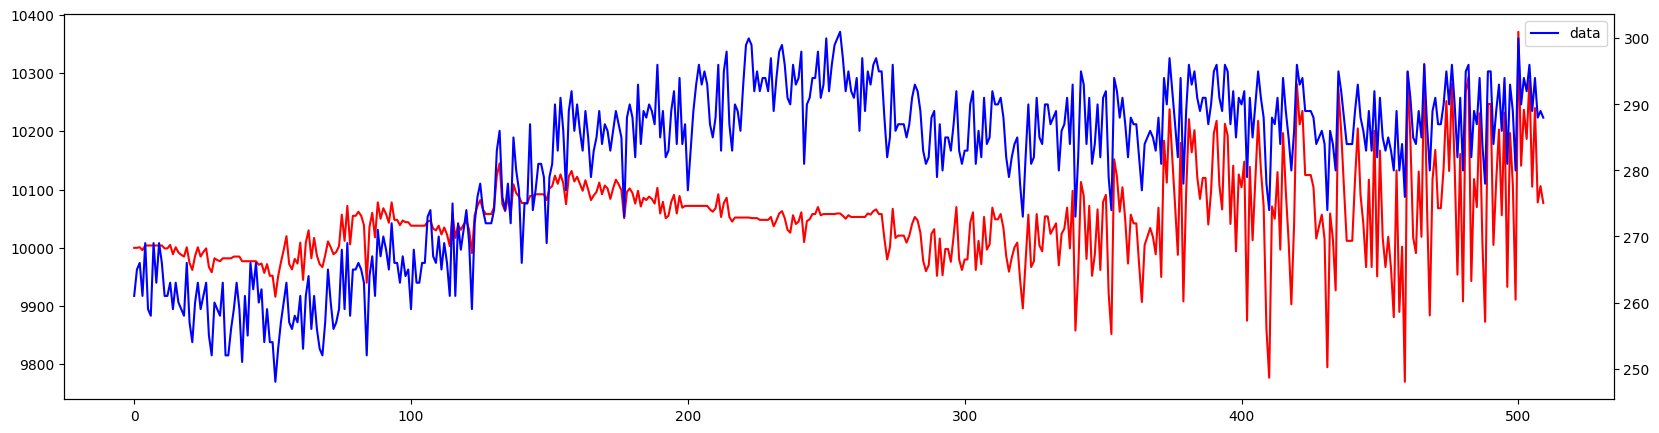

In [4]:
display_results(results, tapes_data[0])

# MA investigation

In [5]:
@njit
def MA_actor(current_data, current_cash, current_stocks):
    if len(current_data) == 0:
        return 0

    window = 2
    ma = np.mean(current_data[-window:])

    if ma > current_data[-1]:
        return 1
    else:
        return 2

profits = []

for i, data in enumerate(tapes_data):
    print(i, end = "\r")
    results = broker(MA_actor, data, cash)
    profits.append(results[-1])

np.mean(profits)

0.022551999999999992

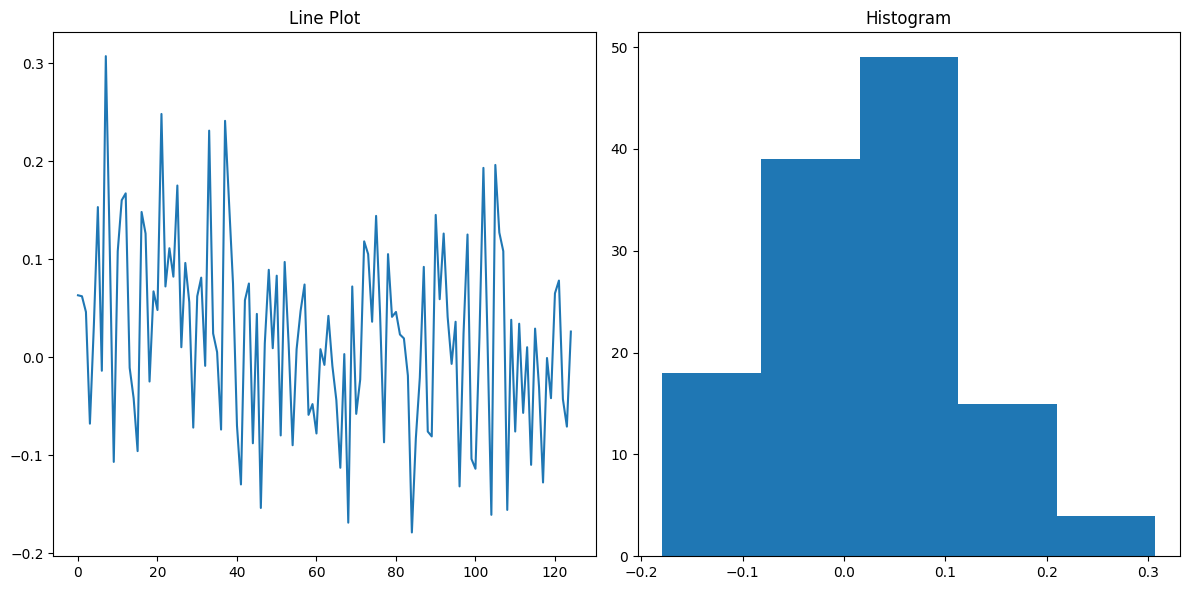

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot line plot on the first subplot
axs[0].plot(profits)
axs[0].set_title('Line Plot')

# Plot histogram on the second subplot
axs[1].hist(profits, bins=5)  # You can adjust the number of bins as needed
axs[1].set_title('Histogram')

# Show the plot
plt.tight_layout()
plt.show()

# Grid Search

In [7]:
cash_values = np.arange(500,2501,500)
windows = 2 ** np.arange(1,14)

grid_profits = np.zeros((len(windows), len(cash_values)))

for i in range(len(windows)):
    for j in range(len(cash_values)):
        print((i,j), end = "\r")    
        
        @njit
        def MA_actor(current_data, current_cash, current_stocks):
            if len(current_data) == 0:
                return 0

            window = windows[i]
            ma = np.mean(current_data[-window:])

            if ma > current_data[-1]:
                return 1
            else:
                return 2
        
        profits = []
        for data in tapes_data:
            results = broker(MA_actor, data, cash_values[j])
            profits.append(results[-1])

        grid_profits[i, j] = np.mean(profits)

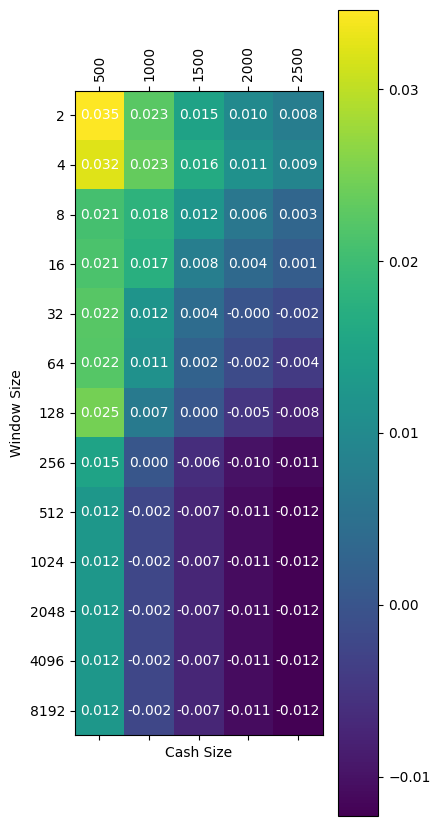

In [14]:
plt.matshow(grid_profits)

plt.yticks(np.arange(len(windows)),[str(a) for a in windows])
plt.ylabel("Window Size")

plt.xticks(np.arange(len(cash_values)),[str(a) for a in cash_values], rotation = 90)
plt.xlabel("Cash Size")

for i in range(len(windows)):
    for j in range(len(cash_values)):
        plt.text(j, i, '{:.3f}'.format(grid_profits[i, j]), ha='center', va='center', color='white')


plt.colorbar()

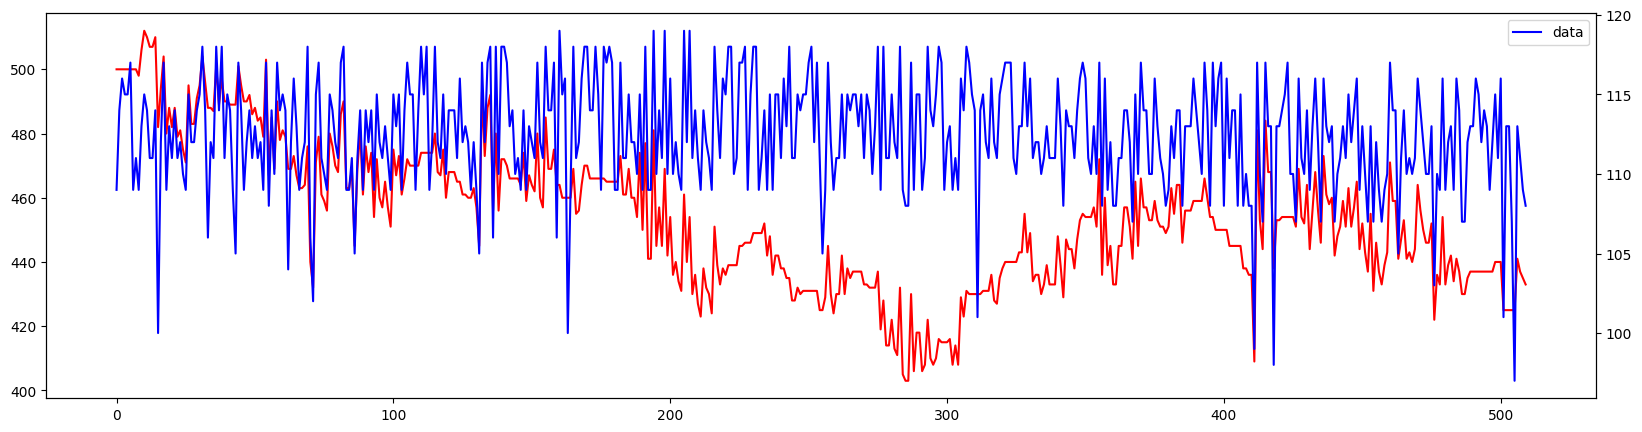

-0.134


In [34]:
@njit
def MA_actor_optimal(current_data, current_cash, current_stocks):
    if len(current_data) == 0:
        return 0

    window = 128
    ma = np.mean(current_data[-window:])

    if ma > current_data[-1]:
        return 1
    else:
        return 2

results = broker(MA_actor_optimal, tapes_data[110], 500)
display_results(results, tapes_data[110])
print(results[-1])

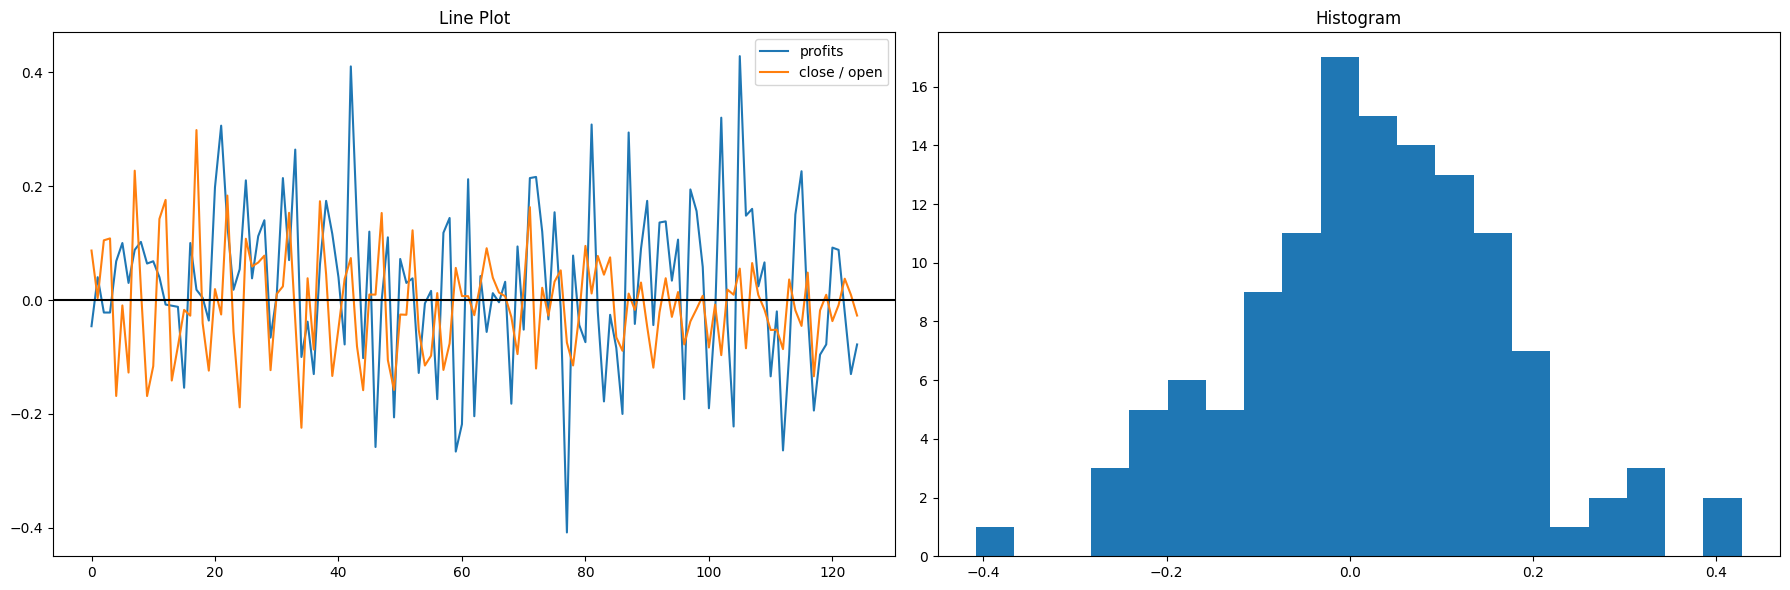

0.03268868484797926


In [39]:
profits = []
open_vs_close = []

for data in tapes_data:
    results = broker(MA_actor_optimal, data, 500)
    profits.append(results[-1])
    open_vs_close.append(data[-1] / data[1] - 1)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot line plot on the first subplot
axs[0].plot(profits, label = "profits")
axs[0].plot(open_vs_close, label = "close / open")
axs[0].set_title('Line Plot')
axs[0].axhline(0, color = "black")
axs[0].legend()

# Plot histogram on the second subplot
axs[1].hist(profits, bins=20)  # You can adjust the number of bins as needed
axs[1].set_title('Histogram')

# Show the plot
plt.tight_layout()
plt.show()

print(np.mean(np.array(profits) - np.array(open_vs_close)))